In [1]:
from pathlib import Path

import cdsapi

# Data will be downloaded here.
download_path = Path("~/downloads/era5")

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2023-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2023-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")

2025-07-08 07:52:17,582 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Static variables downloaded!
Surface-level variables downloaded!
Atmospheric variables downloaded!


In [2]:
import torch
import xarray as xr

from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

batch = Batch(
    surf_vars={
        # First select the first two time points: 00:00 and 06:00. Afterwards, `[None]`
        # inserts a batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[:2][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[:2][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[:2][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[:2][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[:2][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[:2][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[:2][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[:2][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[:2][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select element 1, corresponding to time
        # 06:00.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

In [4]:
if not run_on_foundry:
    from aurora import Aurora, rollout

    model = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
    model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

    model.eval()
    model = model.to("cpu")

    with torch.inference_mode():
        preds = [pred.to("cpu") for pred in rollout(model, batch, steps=1)]

    model = model.to("cpu")

IndexError: list index out of range

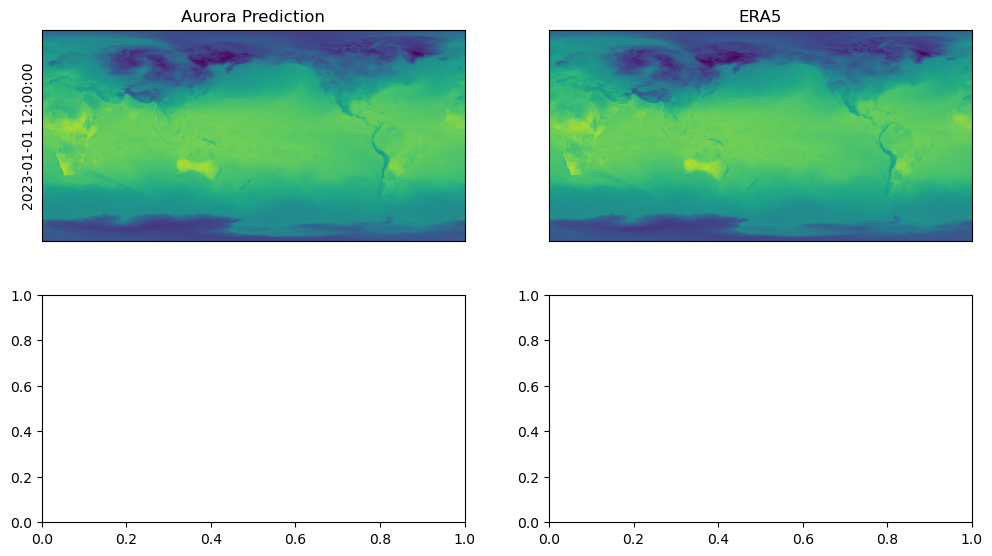

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].imshow(surf_vars_ds["t2m"][2 + i].values - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("ERA5")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()

In [ ]:
import numpy as np

# Convert lat/lon from tensor to numpy arrays
latitudes = batch.metadata.lat.numpy()
longitudes = batch.metadata.lon.numpy()

# Convert LA lon to 0–360 range
la_lat = 34.05
la_lon = 360 - 118.25  # = 241.75

# Find nearest index
lat_idx = np.abs(latitudes - la_lat).argmin()
lon_idx = np.abs(longitudes - la_lon).argmin()

# Prediction at lead step i (i = 0 → +6h, i = 1 → +12h)
pred_temp_K = preds[0].surf_vars["2t"][0, 0, lat_idx, lon_idx].item()
pred_temp_C = pred_temp_K - 273.15
print(f"Aurora 12h-ahead prediction for LA: {pred_temp_C:.2f} °C")

truth_temp_K = surf_vars_ds["t2m"][3].values[lat_idx, lon_idx]
truth_temp_C = truth_temp_K - 273.15
print(f"ERA5 truth for LA at same time: {truth_temp_C:.2f} °C")


Aurora 12h-ahead prediction for LA: 11.52 °C
ERA5 truth for LA at same time: 13.70 °C


In [18]:
def to_360(lon):
    return lon if lon >= 0 else 360 + lon

In [19]:
cities = {
    "Los Angeles": (34.05, -118.24),
    "Chicago": (41.88, -87.63),
    "Austin": (30.27, -97.74),
    "New York City": (40.71, -74.01),
    "Miami": (25.76, -80.19),
    "Philadelphia": (39.95, -75.17),
    "Denver": (39.74, -104.99)
}

In [22]:
def predict_daily_max_for_city(date, model, static_ds, base_path, city_lat, city_lon, steps=6):
    """
    Runs Aurora for a single date and returns the max forecasted temperature (°C) for LA.

    Args:
        date (datetime): Date to forecast
        model (Aurora): Aurora model (already loaded)
        static_ds (xarray.Dataset): Static variables
        base_path (Path): Path to folder with ERA5 files
        steps (int): Number of rollout steps (6 = 24h)

    Returns:
        dict: {"date": date, "max_temp_C": float}
    """
    import torch
    import xarray as xr
    import numpy as np
    from aurora import Batch, Metadata, rollout

    ymd = date.strftime("%Y-%m-%d")
    surf_file = base_path / f"{ymd}-surface-level.nc"
    atmos_file = base_path / f"{ymd}-atmospheric.nc"

    # Load .nc files
    surf_ds = xr.open_dataset(surf_file)
    atmos_ds = xr.open_dataset(atmos_file)

    # LA region crop: 4°x4°
    la_lat = city_lat
    la_lon = to_360(city_lon)
    lat_min, lat_max = la_lat - 2, la_lat + 2
    lon_min, lon_max = la_lon - 2, la_lon + 2

    def crop(ds):  # Inner helper
        if ds.longitude.max() > 180:
            ds = ds.assign_coords(longitude=(ds.longitude % 360))
        return ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

    surf_tile = crop(surf_ds)
    atmos_tile = crop(atmos_ds)
    static_tile = crop(static_ds)

    # Construct batch
    batch = Batch(
        surf_vars={
            "2t": torch.from_numpy(surf_tile["t2m"].values[:2][None]),
            "10u": torch.from_numpy(surf_tile["u10"].values[:2][None]),
            "10v": torch.from_numpy(surf_tile["v10"].values[:2][None]),
            "msl": torch.from_numpy(surf_tile["msl"].values[:2][None]),
        },
        static_vars={
            "z": torch.from_numpy(static_tile["z"].values[0]),
            "slt": torch.from_numpy(static_tile["slt"].values[0]),
            "lsm": torch.from_numpy(static_tile["lsm"].values[0]),
        },
        atmos_vars={
            "t": torch.from_numpy(atmos_tile["t"].values[:2][None]),
            "u": torch.from_numpy(atmos_tile["u"].values[:2][None]),
            "v": torch.from_numpy(atmos_tile["v"].values[:2][None]),
            "q": torch.from_numpy(atmos_tile["q"].values[:2][None]),
            "z": torch.from_numpy(atmos_tile["z"].values[:2][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_tile.latitude.values),
            lon=torch.from_numpy(surf_tile.longitude.values),
            time=(surf_tile.valid_time.values.astype("datetime64[s]").tolist()[1],),
            atmos_levels=tuple(int(l) for l in atmos_tile.pressure_level.values),
        )
    )

    # Run prediction
    model.eval()
    with torch.inference_mode():
        preds = list(rollout(model, batch, steps=steps))

    # Find LA grid point
    lat = preds[0].metadata.lat.numpy()
    lon = preds[0].metadata.lon.numpy()
    i = np.abs(lat - la_lat).argmin()
    j = np.abs(lon - la_lon).argmin()

    # Extract max temp over prediction steps
    max_temp_C = max(
        (pred.surf_vars["2t"][0, 0, i, j].item() - 273.15) for pred in preds
    )

    return {"date": date.date(), "max_temp_C": max_temp_C}


In [13]:
from cdsapi import Client
from pathlib import Path

c = Client()
save_dir = Path("~/downloads/era5").expanduser()
save_dir.mkdir(exist_ok=True)

def download_era5_day(y, m, d):
    date_str = f"{y:04d}-{m:02d}-{d:02d}"
    times = ["00:00", "06:00", "12:00", "18:00"]

    # Surface-level
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "mean_sea_level_pressure"],
            "year": f"{y:04d}",
            "month": f"{m:02d}",
            "day": f"{d:02d}",
            "time": times,
            "format": "netcdf",
        },
        str(save_dir / f"{date_str}-surface-level.nc")
    )

    # Atmospheric-level
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": ["temperature", "u_component_of_wind", "v_component_of_wind", "specific_humidity", "geopotential"],
            "pressure_level": ["50", "100", "150", "200", "250", "300", "400", "500", "600", "700", "850", "925", "1000"],
            "year": f"{y:04d}",
            "month": f"{m:02d}",
            "day": f"{d:02d}",
            "time": times,
            "format": "netcdf",
        },
        str(save_dir / f"{date_str}-atmospheric.nc")
    )


2025-07-08 09:33:39,092 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


In [ ]:
from datetime import datetime, timedelta

start = datetime(2025, 1, 1)
end = datetime(2025, 1, 7)

for i in range((end - start).days):
    dt = start + timedelta(days=i)
    print(f"Downloading {dt.date()}...")
    download_era5_day(dt.year, dt.month, dt.day)


2025-07-08 09:33:59,603 INFO Request ID is 6dbec110-992e-44c0-84a4-cc129655c9df
2025-07-08 09:34:00,797 INFO status has been updated to accepted
2025-07-08 09:34:26,947 INFO status has been updated to successful


249a44b7b67c62bb9e5b22bf51439a09.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 09:34:32,904 INFO Request ID is 53264be0-8398-4642-afde-43eb19609f15
2025-07-08 09:34:33,155 INFO status has been updated to accepted
2025-07-08 09:34:42,695 INFO status has been updated to running
2025-07-08 09:34:47,988 INFO status has been updated to successful


51d08b7f46708a398cd5d56d9f4b827e.nc:   0%|          | 0.00/426M [00:00<?, ?B/s]

2025-07-08 09:36:42,026 INFO Request ID is 30fb8f28-8ac7-4234-a641-c5b0224f81d9
2025-07-08 09:36:42,283 INFO status has been updated to accepted
2025-07-08 09:36:51,908 INFO status has been updated to running
2025-07-08 09:37:16,791 INFO status has been updated to successful


a1aa74ae1b598b1b6da3e8106a2d0ab3.nc:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

2025-07-08 09:37:23,248 INFO Request ID is 5a34de8e-673a-4e9b-80da-b834356622f7
2025-07-08 09:37:23,459 INFO status has been updated to accepted
2025-07-08 09:37:40,393 INFO status has been updated to running
2025-07-08 09:37:48,331 INFO status has been updated to accepted
2025-07-08 09:38:00,005 INFO status has been updated to running
2025-07-08 09:39:21,908 INFO status has been updated to successful


cac44081b1a14c56d69bc61b6069c397.nc:   0%|          | 0.00/429M [00:00<?, ?B/s]

2025-07-08 09:41:31,668 INFO Request ID is 829c850a-5b07-4064-8785-dda87adddfdb
2025-07-08 09:41:31,892 INFO status has been updated to accepted
2025-07-08 09:41:41,751 INFO status has been updated to running
2025-07-08 09:41:54,855 INFO status has been updated to successful


72b1c7137393e175eaa43851c57a664d.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 09:42:00,068 INFO Request ID is ed88b956-01b9-4271-af69-af64c119a94c
2025-07-08 09:42:00,337 INFO status has been updated to accepted
2025-07-08 09:42:09,721 INFO status has been updated to running
2025-07-08 09:43:56,507 INFO status has been updated to successful


40b8e4cae2c04456c4632fe30a0c87c3.nc:   0%|          | 0.00/420M [00:00<?, ?B/s]

2025-07-08 09:45:48,746 INFO Request ID is 33d4c7df-799c-441e-a1ec-24cc3d8d490e
2025-07-08 09:45:48,985 INFO status has been updated to accepted
2025-07-08 09:46:04,082 INFO status has been updated to running
2025-07-08 09:46:11,917 INFO status has been updated to successful


f6a375f44bc58b040f17f68a2e98e912.nc:   0%|          | 0.00/26.1M [00:00<?, ?B/s]

2025-07-08 09:46:18,353 INFO Request ID is f8a9aef3-9f34-4edd-87bf-5ce0002eb6f4
2025-07-08 09:46:18,572 INFO status has been updated to accepted
2025-07-08 09:46:28,180 INFO status has been updated to running
2025-07-08 09:48:14,905 INFO status has been updated to successful


e5ec9cc71d5a036ac4a82f6e26dded58.nc:   0%|          | 0.00/416M [00:00<?, ?B/s]

2025-07-08 09:50:02,958 INFO Request ID is 444bd7be-444a-4665-85aa-1dbafe480b48
2025-07-08 09:50:03,371 INFO status has been updated to accepted
2025-07-08 09:50:12,513 INFO status has been updated to running
2025-07-08 09:50:37,227 INFO status has been updated to successful


8af76ac69a1c752208d221d25def1897.nc:   0%|          | 0.00/26.1M [00:00<?, ?B/s]

2025-07-08 09:50:53,961 INFO Request ID is 750183c5-22b0-4e93-9794-200032d25a50
2025-07-08 09:50:54,172 INFO status has been updated to accepted
2025-07-08 09:51:08,700 INFO status has been updated to running
2025-07-08 09:53:48,870 INFO status has been updated to successful


627556d1209c656365148db73df4e601.nc:   0%|          | 0.00/425M [00:00<?, ?B/s]

2025-07-08 09:56:59,820 INFO Request ID is 76de5e4c-67b5-40bd-906f-33689ae0627e
2025-07-08 09:57:00,151 INFO status has been updated to accepted
2025-07-08 09:57:14,576 INFO status has been updated to running
2025-07-08 09:57:22,552 INFO status has been updated to successful


d4a4e0a458fe8512161015e1a455126d.nc:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

2025-07-08 09:57:28,155 INFO Request ID is d54f4c89-a9f7-4b29-b2f2-4688ceac9a63
2025-07-08 09:57:28,363 INFO status has been updated to accepted
2025-07-08 09:57:38,009 INFO status has been updated to running
2025-07-08 09:59:24,755 INFO status has been updated to successful


b3218e66413fdda30acf4dff8fb7394b.nc:   0%|          | 0.00/424M [00:00<?, ?B/s]


🌆 Forecasting for Los Angeles

🌆 Forecasting for Chicago

🌆 Forecasting for Austin

🌆 Forecasting for New York City

🌆 Forecasting for Miami

🌆 Forecasting for Philadelphia

🌆 Forecasting for Denver


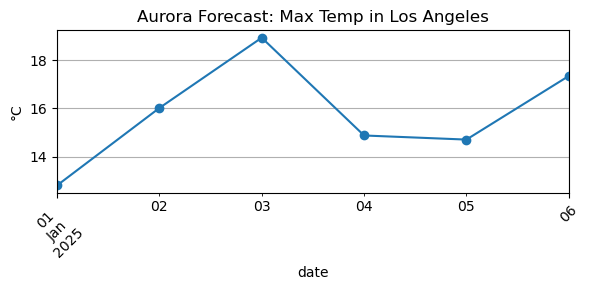

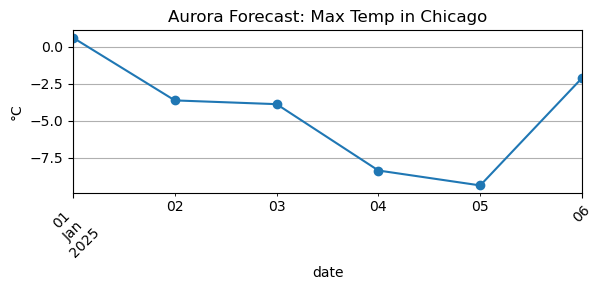

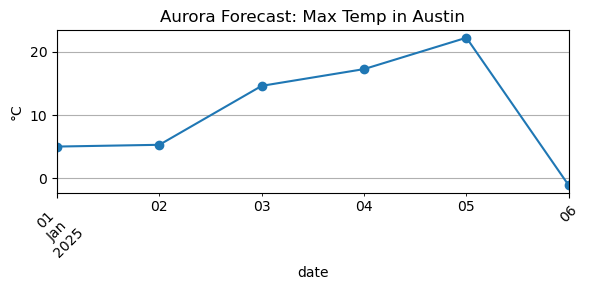

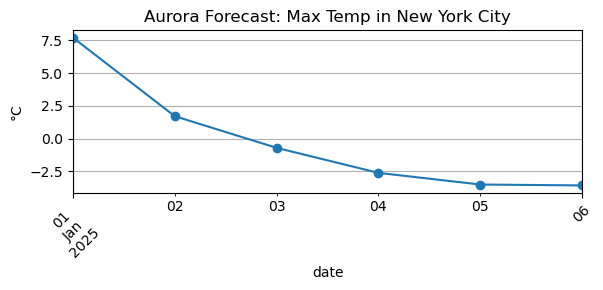

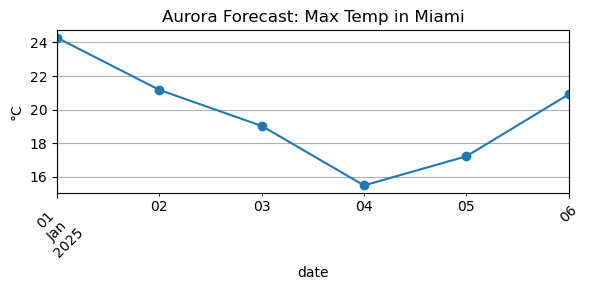

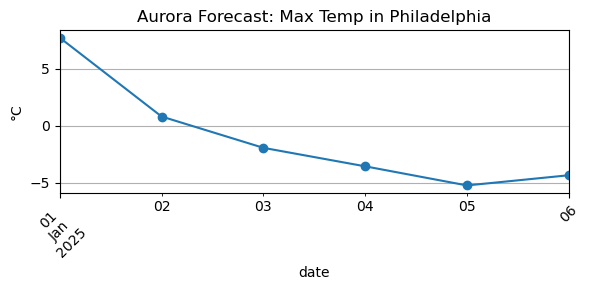

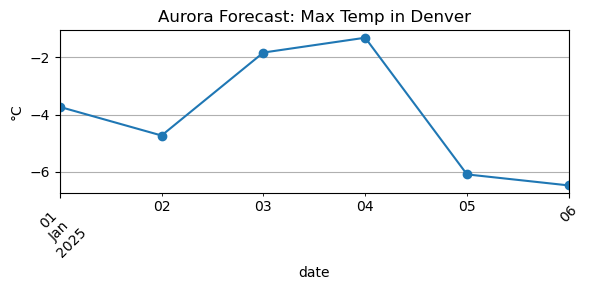

In [23]:
from datetime import datetime, timedelta

start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 1, 7)

static_ds = xr.open_dataset(base_path / "static.nc")
model = Aurora(use_lora=False)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")
model = model.to("cpu")

all_results = []

for city, (lat, lon) in cities.items():
    print(f"\n🌆 Forecasting for {city}")
    for n in range((end_date - start_date).days):
        day = start_date + timedelta(days=n)
        try:
            forecast = predict_daily_max_for_city(day, model, static_ds, base_path, lat, lon)
            forecast["city"] = city
            all_results.append(forecast)
        except FileNotFoundError:
            print(f"Missing data for {city} on {day.date()}")

df_all = pd.DataFrame(all_results)
df_all["date"] = pd.to_datetime(df_all["date"])

# Plot each city separately
import matplotlib.pyplot as plt

for city in df_all["city"].unique():
    df_city = df_all[df_all["city"] == city].set_index("date")
    
    plt.figure(figsize=(6, 3))
    df_city["max_temp_C"].plot(marker="o", title=f"Aurora Forecast: Max Temp in {city}")
    plt.ylabel("°C")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [24]:
def get_era5_max_for_city(date, base_path, city_lat, city_lon):
    import xarray as xr
    import numpy as np

    file_path = base_path / f"{date.strftime('%Y-%m-%d')}-surface-level.nc"
    ds = xr.open_dataset(file_path)

    # Convert longitudes if needed
    if ds.longitude.max() > 180:
        ds = ds.assign_coords(longitude=(ds.longitude % 360))

    latitudes = ds.latitude.values
    longitudes = ds.longitude.values

    lat_idx = np.abs(latitudes - city_lat).argmin()
    lon_idx = np.abs(longitudes - to_360(city_lon)).argmin()

    temps_K = ds["t2m"].values[:, lat_idx, lon_idx]
    max_temp_C = temps_K.max() - 273.15

    return float(max_temp_C)


In [25]:
all_results = []

for city, (lat, lon) in cities.items():
    print(f"\n🌆 Processing {city}")
    for n in range((end_date - start_date).days):
        day = start_date + timedelta(days=n)
        try:
            forecast = predict_daily_max_for_city(day, model, static_ds, base_path, lat, lon)
            actual = get_era5_max_for_city(day, base_path, lat, lon)

            all_results.append({
                "date": day.date(),
                "city": city,
                "forecast_C": forecast["max_temp_C"],
                "truth_C": actual
            })

        except FileNotFoundError:
            print(f"Missing file for {city} on {day.date()}")


🌆 Processing Los Angeles


: 

In [ ]:
df = pd.DataFrame(all_results)
df["date"] = pd.to_datetime(df["date"])

for city in df["city"].unique():
    df_city = df[df["city"] == city].set_index("date")

    plt.figure(figsize=(6, 3))
    plt.plot(df_city.index, df_city["forecast_C"], marker="o", label="Aurora Forecast")
    plt.plot(df_city.index, df_city["truth_C"], marker="x", label="ERA5 Actual")
    plt.title(f"{city}: Daily Max Temp")
    plt.ylabel("°C")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
